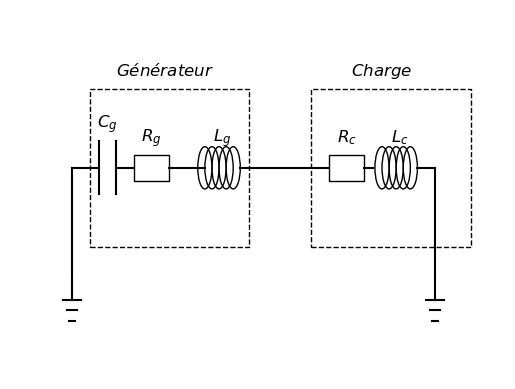

interactive(children=(FloatSlider(value=40.0, description='Tension initiale Vc (Vc0) en kV:', step=1.0, style=…

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets
from IPython.display import display, Latex, HTML
from scipy.signal import TransferFunction, bode

def draw_ground_symbol(ax, x, y):
    """Dessine un symbole de terre standardisé à la position (x, y)."""
    line_length = 0.5  # Longueur de la ligne principale
    ax.plot([x, x], [y, y - line_length], color="black")  # Ligne verticale
    
    # Trois lignes horizontales de terre
    ax.plot([x - 0.5, x + 0.5], [y - line_length, y - line_length], color="black")
    ax.plot([x - 0.3, x + 0.3], [y - line_length - 0.2, y - line_length - 0.2], color="black")
    ax.plot([x - 0.15, x + 0.15], [y - line_length - 0.4, y - line_length - 0.4], color="black")


display(HTML("<u>Schéma électrique considéré:</u>"))

fig, ax = plt.subplots()

# Étendre les limites du graphique pour éviter le découpage
ax.set_xlim(-3, 25)
ax.set_ylim(0, 7)

# Masquer les axes
ax.axis('off')

# Dessiner le symbole de terre amélioré à gauche avant Cg
draw_ground_symbol(ax, 0.5, 2)  # Terre à gauche avant Cg

# Ajouter un fil vertical partant de la terre à gauche vers le haut
ax.plot([0.5, 0.5], [2, 4], color="black", lw=1.5)  # Fil vertical partant de la terre vers le haut

# Ajouter un fil à gauche de Cg
ax.plot([0.5, 2], [4, 4], color="black", lw=1.5)  # Fil à gauche de Cg

# Dessiner un condensateur avec une représentation plus conventionnelle
ax.plot([2, 2], [3.5, 4.5], color="black")  # Ligne verticale pour la première plaque
ax.plot([3, 3], [3.5, 4.5], color="black")  # Ligne verticale pour la seconde plaque
ax.text(2.5, 4.75, "$C_{g}$", fontsize=12, ha='center')  # Étiquette du condensateur

# Connexion entre le condensateur et la résistance
ax.plot([3, 4], [4, 4], color="black", lw=1.5)  # Connexion C à R

# Dessiner une résistance sous forme de rectangle pour Rg
ax.add_patch(patches.Rectangle((4, 3.75), 2, 0.5, edgecolor='black', facecolor='none'))  # Corps de la résistance
ax.text(5, 4.5, "$R_{g}$", fontsize=12, ha='center')  # Étiquette de la résistance

# Dessiner une bobine (inductance) pour Lg
ax.plot([6, 8], [4, 4], color="black")  # Fils vers la bobine
for i in range(5):
    ax.add_patch(patches.Circle((8 + i*0.4, 4), 0.4, edgecolor='black', facecolor='none'))
ax.text(9, 4.5, "$L_{g}$", fontsize=12, ha='center')

# Dessiner une résistance sous forme de rectangle pour Rc
ax.add_patch(patches.Rectangle((15, 3.75), 2, 0.5, edgecolor='black', facecolor='none'))  # Corps de la résistance Rc
ax.plot([10, 15], [4, 4], color="black", lw=1.5)  #  fil avant Rc
ax.plot([17, 17.5], [4, 4], color="black", lw=1.5)  #  fil après Rc
ax.text(16, 4.5, "$R_{c}$", fontsize=12, ha='center')  # Étiquette de la résistance Rc

# Dessiner une bobine (inductance) pour Lc plus à droite
for i in range(5):
    ax.add_patch(patches.Circle((18 + i*0.4, 4), 0.4, edgecolor='black', facecolor='none'))
ax.plot([20, 21], [4, 4], color="black", lw=1.5)  # Ajuster selon la nouvelle fin du schéma
ax.text(19, 4.5, "$L_{c}$", fontsize=12, ha='center')

# Ajouter un fil vertical partant de la terre à gauche vers le haut
ax.plot([21, 21], [2, 4], color="black", lw=1.5)  # Fil vertical partant de la terre vers le haut

# Dessiner les symboles de terre améliorés à droite après Lc
draw_ground_symbol(ax, 21, 2)  # Terre à droite après Lc

# Ajouter un cadre rectangulaire pointillé autour de Cg, Rg, et Lg
ax.add_patch(patches.Rectangle((1.5, 2.5), 9, 3, linewidth=1, edgecolor='black', facecolor='none', linestyle='--'))
ax.text(5.75, 5.75, "$Générateur$", fontsize=12, ha='center')  
# Ajouter un cadre rectangulaire pointillé autour de Rc et Lc
ax.add_patch(patches.Rectangle((14, 2.5), 9, 3, linewidth=1, edgecolor='black', facecolor='none', linestyle='--'))
ax.text(18, 5.75, "$Charge$", fontsize=12, ha='center')  

plt.show()


display(HTML('<br>'))  # Pour un simple saut de ligne
display(HTML("<u>Paramètres de réglage:</u>"))

# Définition du style pour les sliders
slider_style = {'description_width': 'initial', 'handle_color': 'lightblue'}

def rlc(A, t, Rg_mOhm, Rc_mOhm, Lg_nH, Lc_nH, C_uF):
    """
    Fonction décrivant l'ODE pour un circuit RLC.
    A : Vecteur contenant les variables d'état du système. Dans le contexte d'un circuit RLC, il 
    s'agit généralement de la tension aux bornes du condensateur Vc et de la dérivée temporelle de cette tension dVc/dt
    t : temps
    R, L, C : paramètres du circuit
    V : fonction définissant la tension appliquée
    """
    Vc, x = A
    V = 0.0              # Tension de la source en Volts
    Rg = Rg_mOhm * 1e-3  # Convertir Rg de mΩ en Ω
    Rc = Rc_mOhm * 1e-3  # Convertir Rc de mΩ en Ω
    R = Rg + Rc          # La résistance totale en Ohms
    Lg = Lg_nH * 1e-9    # Convertir Lg de nH en H
    Lc = Lc_nH * 1e-9    # Convertir Lc de nH en H
    C = C_uF * 1e-6      # Convertir C de µF en F
    L = Lg + Lc          # L'inductance totale en Henrys
    res = np.array([x, (V - Vc - (x * R * C)) / (L * C)])
    return res

def run_simulation(Vc0_kV, C_uF, Rg_mOhm, Rc_mOhm, Lg_nH, Lc_nH):
    Vc0 = Vc0_kV * 1000  # Convertir la tension initiale de kV en Volts
    time = np.linspace(0.0, 20e-6, 1001)  # Couvre jusqu'à 20 microsecondes
    vc, x = odeint(rlc, [Vc0, 0.0], time, args=(Rg_mOhm, Rc_mOhm, Lg_nH, Lc_nH, C_uF)).T
    i=-x*C_uF* 1e-6
    di_dt = np.diff(i) / np.diff(time)
    # Ajout d'une valeur fictive à la fin pour garder la même longueur que le tableau 'time'
    di_dt = np.append(di_dt, di_dt[-1])
    # calcul de la tension sur la charge (Rc+Lc):
    VChargeRL= Rc_mOhm* 1e-3*i + Lc_nH* 1e-9 *di_dt

    # Calcul de la valeur maximale du courant en MA
    I_max_MA = np.max(i) / 1e6  # Convertir en MA
    idx_max = np.argmax(i)  # Trouver l'indice du maximum de courant
    time_max_I = time[idx_max]  # Temps correspondant au maximum de courant

    # Calcul de la pulsation propre
    Lg = Lg_nH * 1e-9  # Convertir Lg de nH en H
    Lc = Lc_nH * 1e-9  # Convertir Lc de nH en H
    L = Lg + Lc  # L'inductance totale
    C = C_uF * 1e-6  # Capacité en Farads
    Rg = Rg_mOhm * 1e-3  # Convertir Rg de mΩ en Ω
    Rc = Rc_mOhm * 1e-3  # Convertir Rc de mΩ en Ω
    R = Rg + Rc  # La résistance totale
    omega_0 = 1 / np.sqrt(L * C)  # Calcul de la pulsation propre
    f_MHz = omega_0 / (2 * np.pi * 1e6)  # fréquence propre en MHz
    T_0 = 1 / (omega_0 / (2 * np.pi))  # Période propre en secondes
    
    zeta = R / (2 * np.sqrt(L / C))  # Calcul du facteur d'amortissement
    # Détermination du régime du système en fonction de la valeur de zeta
    if zeta < 1:
        regime = "Sous-amorti (oscillant)"
    elif zeta == 1:
        regime = "Critique"
    else:
        regime = "Sur-amorti"
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Graphique de la tension Vc en kV
    ax1.plot(time * 1e6, vc / 1000, 'r')
    ax1.set_xlabel('Temps (µs)')
    ax1.set_ylabel('Tension Vc (kV)')
    ax1.set_title('Tension aux bornes du condensateur en kV')
    ax1.grid(True)

    # Graphique du courant I en MA
    ax2.plot(time * 1e6, i / 1e6, 'b')
    ax2.set_xlabel('Temps (µs)')
    ax2.set_ylabel('Courant (MA)')
    ax2.set_title(f'Courant dans le circuit RLC \n  ')
    ax2.grid(True)

    # Graphique de la tension sur la charge (Rc+Lc) en Volts
    ax3.plot(time * 1e6, VChargeRL/ 1000, 'g')
    ax3.set_xlabel('Temps (µs)')
    ax3.set_ylabel('Tension sur la charge (kV)')
    ax3.set_title('Tension sur la charge (Rc+Lc)')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

    # Affichage de l'équation de la pulsation propre en LaTeX
    display(Latex(f'Pulsation propre du système $\\quad \\omega_0 = \\frac{{1}}{{\\sqrt{{LC}}}}: {omega_0:.2f}\\,\\text{{rad/s}}$'))
    display(Latex(f'Fréquence propre du système $\\quad f = \\frac{{\\omega_0}}{{2\\pi}} = {f_MHz:.2f} \\, \\text{{MHz}}, \\quad$ Période propre du système  $T= \\frac {{1}}{{f}}= {T_0 * 1e6:.2f} \micro s $  ')),
    display(Latex(f'Facteur amortissement $\\quad \\zeta = \\frac{{R}}{{2\\sqrt{{\\frac{{L}}{{C}}}}}} = {zeta:.2f} \\quad (\\text{{Régime : {regime}}}) $')),
    display(Latex(f'Courant max: $\\quad T_m = {I_max_MA:.2f} MA$')),
    display(Latex(f'Temps de montée: $\\quad T_m = {time_max_I * 1e6:.2f} \\, \\text{{µs}}$'))

# Partie calcul fonction de transfert et diagramme de Bode:
    # Définition de la fonction de transfert
    Rg = Rg_mOhm * 1e-3  # mOhm en Ohm
    Lg = Lg_nH * 1e-9    # nH en H
    C = C_uF * 1e-6      # uF en F
    num = [1]
    den = [Lg*C, Rg*C, 1]
    system = TransferFunction(num, den)

     # Calcul du diagramme de Bode
    frequencies, mag, phase = bode(system)

    display(HTML('<br>'))  # Pour un simple saut de ligne
    display(HTML("<u>Fonction de transfert du circuit RgLgC (partie générateur):</u>"))
    display(HTML('<br>'))  # Pour un simple saut de ligne
    
    # Affichage
   # plt.figure(figsize=(12, 6))
    fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 6))

    # Magnitude
    ax4.semilogx(frequencies, mag)  # Bode magnitude plot
    ax4.set_title('Diagramme de Bode - Magnitude')  # Correction ici
    ax4.set_xlabel('Fréquence (rad/s)')  # Correction ici
    ax4.set_ylabel('Amplitude (dB)')  # Correction ici
    ax4.minorticks_on()  # Active les ticks mineurs
    ax4.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Grille principale plus visible
    ax4.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')  # Grille secondaire plus fine

# Phase
    
    # Phase
    ax5.semilogx(frequencies, phase)  # Bode phase plot
    ax5.set_title('Diagramme de Bode - Phase')  # Correction ici
    ax5.set_xlabel('Fréquence (rad/s)')  # Correction ici
    ax5.set_ylabel('Phase (degrés)')  # Correction ici
    ax5.grid(True)  # Ajout de la grille
    ax5.minorticks_on()  # Active les ticks mineurs
    ax5.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Grille principale plus visible
    ax5.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')  # Grille secondaire plus fine

    plt.tight_layout()
    plt.show()

    
interact(run_simulation,
         Vc0_kV=FloatSlider(value=40, min=0.0, max=100.0, step=1.0, description='Tension initiale Vc (Vc0) en kV:', style=slider_style),
         C_uF=FloatSlider(value=20.0, min=0.001, max=100.0, step=0.01, description='Capacité (C) en µF:', style=slider_style),
         Rg_mOhm=FloatSlider(value=2.5, min=0., max=1000, step=0.1, description='Résistance Rg (mΩ):', style=slider_style),
         Rc_mOhm=FloatSlider(value=0.5, min=0, max=10000.0, step=0.1, description='Résistance Rc (mΩ):', style=slider_style),
         Lg_nH=FloatSlider(value=2, min=0, max=100, step=0.1, description='Inductance Lg (nH):', style=slider_style),
         Lc_nH=FloatSlider(value=5, min=0, max=100, step=0.1, description='Inductance Lc (nH):', style=slider_style)
        );

